In [1]:
import os
import re
import sys
import json
import time
import gspread
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

In [4]:
%matplotlib notebook

In [5]:
areas_of_interest = {
    'MO': [
        'MOp1', 'MOp2/3', 'MOp5', 'MOp6a', 'MOp6b',
        'MOs1', 'MOs2/3', 'MOs5', 'MOs6a', 'MOs6b'
    ],
#     'ACA': [
#         'ACAd1', 'ACAd2/3', 'ACAd5', 'ACAd6a', 'ACAd6b',
#         'ACAv1', 'ACAv2/3', 'ACAv5', 'ACAv6a', 'ACAv6b'
#     ],
    'SS': [
        'SSp-bfd1', 'SSp-bfd2/3', 'SSp-bfd4', 'SSp-bfd5', 'SSp-bfd6a', 'SSp-bfd6b',
        'SSp-ll1', 'SSp-ll2/3', 'SSp-ll4', 'SSp-ll5', 'SSp-ll6a', 'SSp-ll6b',
        'SSp-tr1', 'SSp-tr2/3', 'SSp-tr4', 'SSp-tr5', 'SSp-tr6a', 'SSp-tr6b'
    ],
    'VIS': [
        'VISp1', 'VISp2/3', 'VISp4', 'VISp5', 'VISp6a', 'VISp6b',
        'VISam1', 'VISam2/3', 'VISam4', 'VISam5', 'VISam6a', 'VISam6b',
        'VISpm1', 'VISpm2/3', 'VISpm4', 'VISpm5', 'VISpm6a', 'VISpm6b',
        'VISrl1', 'VISrl2/3', 'VISrl4', 'VISrl5', 'VISrl6a', 'VISrl6b',
    ],
#     'MO-TH': [
#         'AV', 'CL', 'MD', 'PO', 'RT', 'VAL', 'VPL', 'VPM', 'VM'
#     ],
}

### Load the CCF, both resolutions

In [6]:
mcc10 = MouseConnectivityCache(resolution=10)
annot10, annot10_info = mcc10.get_annotation_volume()
mcc25 = MouseConnectivityCache(resolution=25)
annot25, annot25_info = mcc25.get_annotation_volume()

## Load the subjects and metadata .csv file

In [7]:
multisub_file = r"C:\Users\lesliec\OneDrive - Allen Institute\data\all_subject_metadata.csv"
subject_df = pd.read_csv(multisub_file).astype({'mouse': str})

### Loop through all subjects

In [8]:
all_probe_angles = []
for indi, row in subject_df.iterrows():
    print(row.mouse)
    if row.histology == 'slices':
        annot = annot10
        deltapixel = 25
    elif row.histology == 'TC':
        annot = annot25
        deltapixel = 10
    else:
        print(' No histology, not analyzing.\n')
        continue
    
    ## Load subject data ##
    exp = EEGexp(row.data_loc, preprocess=False, make_stim_csv=False)
    probe_list = [x.replace('_sorted', '') for x in exp.experiment_data if 'probe' in x]
    area_info = {key: {} for key in list(areas_of_interest.keys())}
    area_list = []
    ## Loop through probes ##
    for probei in probe_list:
        with open(exp.ephys_params[probei]['probe_info']) as data_file:
            data = json.load(data_file)
        npx_allch = np.array(data['channel']) # this is an array from 0 to 384
        surface_ch = int(data['surface_channel']) # the electrode we said was at the brain surface
        allch_z = np.array(data['vertical_pos']) # vert position of each ch (um), rel to the tip (ch 0 is 20 um from tip)
        all_ch_depths = allch_z[surface_ch] - allch_z

        if 'area_ch' in data.keys():
            ch_areas = np.array(data['area_ch'])
            ch_CCF_coords = np.array(data['ccf_coord_ch'])
            parent_areas = [k for x in np.unique(ch_areas) for k in list(areas_of_interest.keys()) if x in areas_of_interest[k]]
            for ctxarea in np.unique(parent_areas):
                if ctxarea in area_list:
                    continue
                parent_chs = np.array([x for x in npx_allch if ch_areas[x] in areas_of_interest[ctxarea]])
                if len(parent_chs) > 10:
                    area_info[ctxarea]['npxchs'] = parent_chs
                    area_info[ctxarea]['depth'] = all_ch_depths[parent_chs]
                    area_info[ctxarea]['CCF_coords'] = ch_CCF_coords[parent_chs]
                    area_list.append(ctxarea)    
        else:
            print('  {} - no area assignments.'.format(probei))
    
    if len(area_list) == 0:
        print(' No areas found, not analyzing.\n')
        continue
        
    for areai in area_list:
        ## Get probe direction vector ##
        probe_vec = area_info[areai]['CCF_coords'][0,:] - area_info[areai]['CCF_coords'][-1,:]
        unit_probe_vec = probe_vec / np.linalg.norm(probe_vec)

        ## Define insertion point ##
        surfcoords = area_info[areai]['CCF_coords'][np.argmin(area_info[areai]['depth']),:]

        ## Define 3 points surrounding insertion ##
        points = [
            surfcoords + [-deltapixel, 0, 0], # moves anterior by deltapixel
            surfcoords + [deltapixel, 0, 0], # moves posterior by deltapixel
            surfcoords + [0, 0, deltapixel], # moves medial by deltapixel
        ]

        ## Now find surface level ##
        for i, icoords in enumerate(points):
            points[i][1] = np.nonzero(annot[icoords[0], :, icoords[2]])[0][0]

        ## Use 3 points to define plane tangent(?) to surface ##
        p0, p1, p2 = points
        x0, y0, z0 = p0
        x1, y1, z1 = p1
        x2, y2, z2 = p2

        ux, uy, uz = u = [x1-x0, y1-y0, z1-z0]
        vx, vy, vz = v = [x2-x0, y2-y0, z2-z0]

        u_cross_v = [uy*vz-uz*vy, uz*vx-ux*vz, ux*vy-uy*vx]

        surf_normal = -np.array(u_cross_v)
        surf_unit_normal = surf_normal / np.linalg.norm(surf_normal)

        ## Degrees between ##
        probe_angle = np.degrees(np.arccos(np.dot(unit_probe_vec, surf_unit_normal)))
        print('  {}: {:.1f} degrees from parallel to axons'.format(areai, probe_angle))
        all_probe_angles.append(probe_angle)
    print('')

521885
 No histology, not analyzing.

521886
 No histology, not analyzing.

521887
Experiment type: electrical stimulation
 No areas found, not analyzing.

543393
 No histology, not analyzing.

543394
 No histology, not analyzing.

546655
Experiment type: electrical and sensory stimulation
  MO: 21.7 degrees from parallel to axons
  VIS: 22.8 degrees from parallel to axons

551399
Experiment type: electrical stimulation
  SS: 14.5 degrees from parallel to axons
  MO: 20.6 degrees from parallel to axons

551397
Experiment type: electrical and sensory stimulation
  SS: 12.7 degrees from parallel to axons
  MO: 15.0 degrees from parallel to axons

569062
Experiment type: electrical and sensory stimulation
  SS: 8.8 degrees from parallel to axons
  MO: 14.1 degrees from parallel to axons

569068
Experiment type: electrical and sensory stimulation
  SS: 13.5 degrees from parallel to axons
  VIS: 23.2 degrees from parallel to axons
  MO: 7.9 degrees from parallel to axons

569069
Experiment 

In [9]:
all_probe_angles = np.array(all_probe_angles)

In [10]:
print('Mean probe angle = {:.1f} degrees'.format(np.mean(all_probe_angles)))
print('Min: {:.1f} degrees, max: {:.1f} degrees'.format(np.min(all_probe_angles), np.max(all_probe_angles)))

Mean probe angle = 15.3 degrees
Min: 5.2 degrees, max: 36.6 degrees


In [13]:
np.median(all_probe_angles)

13.622099701140332

In [15]:
np.percentile(all_probe_angles, 75)

18.79881462078435

# The subject in Figure 1B is 569069, probeF. The deviation from perpendicular is 31.2 degrees.

#### Test with one subject

In [37]:
row = subject_df[subject_df['mouse'] == '569068'].squeeze()
print(row.histology)

slices


In [38]:
if row.histology == 'slices':
    annot = annot10
    deltapixel = 25
elif row.histology == 'TC':
    annot = annot25
    deltapixel = 10
else:
    print('No histology, not analyzing.')

In [39]:
row.data_loc

'F:\\EEG_exp\\mouse569068\\estim_vis_2021-03-04_10-51-38\\experiment1\\recording1'

In [40]:
exp = EEGexp(row.data_loc, preprocess=False, make_stim_csv=False)
probe_list = [x.replace('_sorted', '') for x in exp.experiment_data if 'probe' in x]
print(probe_list)

Experiment type: electrical and sensory stimulation
['probeB', 'probeD', 'probeF']


In [42]:
area_info = {key: {} for key in list(areas_of_interest.keys())}
area_list = []
for probei in probe_list:
    print(probei)
    with open(exp.ephys_params[probei]['probe_info']) as data_file:
        data = json.load(data_file)
    npx_allch = np.array(data['channel']) # this is an array from 0 to 384
    surface_ch = int(data['surface_channel']) # the electrode we said was at the brain surface
    allch_z = np.array(data['vertical_pos']) # vert position of each ch (um), rel to the tip (ch 0 is 20 um from tip)
    all_ch_depths = allch_z[surface_ch] - allch_z
    
    if 'area_ch' in data.keys():
        ch_areas = np.array(data['area_ch'])
        ch_CCF_coords = np.array(data['ccf_coord_ch'])
        parent_areas = [k for x in np.unique(ch_areas) for k in list(areas_of_interest.keys()) if x in areas_of_interest[k]]
        for ctxarea in np.unique(parent_areas):
            if ctxarea in area_list:
                continue
            print(' {}'.format(ctxarea))
            parent_chs = np.array([x for x in npx_allch if ch_areas[x] in areas_of_interest[ctxarea]])
            if len(parent_chs) > 10:
                area_info[ctxarea]['npxchs'] = parent_chs
                area_info[ctxarea]['depth'] = all_ch_depths[parent_chs]
                area_info[ctxarea]['CCF_coords'] = ch_CCF_coords[parent_chs]
                area_list.append(ctxarea)
            else:
                print('  not enough chs in parent area.')     
    else:
        print(' No area assignments.')

probeB
 SS
probeD
 VIS
probeF
 MO


In [29]:
area_list

['SS', 'VIS', 'MO']

In [30]:
for areai in area_list:
    ## Get probe direction vector ##
    probe_vec = area_info[areai]['CCF_coords'][0,:] - area_info[areai]['CCF_coords'][-1,:]
    unit_probe_vec = probe_vec / np.linalg.norm(probe_vec)

    ## Define insertion point ##
    surfcoords = area_info[areai]['CCF_coords'][np.argmin(area_info[areai]['depth']),:]

    ## Define 3 points surrounding insertion ##
    points = [
        surfcoords + [-deltapixel, 0, 0], # moves anterior by deltapixel
        surfcoords + [deltapixel, 0, 0], # moves posterior by deltapixel
        surfcoords + [0, 0, deltapixel], # moves medial by deltapixel
    ]

    ## Now find surface level ##
    for i, icoords in enumerate(points):
        points[i][1] = np.nonzero(annot[icoords[0], :, icoords[2]])[0][0]

    ## Use 3 points to define plane tangent(?) to surface ##
    p0, p1, p2 = points
    x0, y0, z0 = p0
    x1, y1, z1 = p1
    x2, y2, z2 = p2

    ux, uy, uz = u = [x1-x0, y1-y0, z1-z0]
    vx, vy, vz = v = [x2-x0, y2-y0, z2-z0]

    u_cross_v = [uy*vz-uz*vy, uz*vx-ux*vz, ux*vy-uy*vx]

    surf_normal = -np.array(u_cross_v)
    surf_unit_normal = surf_normal / np.linalg.norm(surf_normal)

    ## Degrees between ##
    probe_angle = np.degrees(np.arccos(np.dot(unit_probe_vec, surf_unit_normal)))
    print(' {}: {:.1f} degrees from parallel'.format(areai, probe_angle))

 SS: 11.1 degrees from parallel
 VIS: 11.3 degrees from parallel
 MO: 26.5 degrees from parallel


# Older testing

### Look at probes from one experiment

In [12]:
rec_folder = r'F:\EEG_exp\mouse586466\estim_vis_2021-07-29_10-37-41\experiment1\recording1' # has 10um CCF
exp = EEGexp(rec_folder, preprocess=False, make_stim_csv=False)

Experiment type: electrical and sensory stimulation


In [13]:
probe_list = [x.replace('_sorted', '') for x in exp.experiment_data if 'probe' in x]
print(probe_list)

['probeB', 'probeC', 'probeF']


In [14]:
area_info = {key: {} for key in list(areas_of_interest.keys())}
for probei in probe_list:
    print(probei)
    with open(exp.ephys_params[probei]['probe_info']) as data_file:
        data = json.load(data_file)
    npx_allch = np.array(data['channel']) # this is an array from 0 to 384
    surface_ch = int(data['surface_channel']) # the electrode we said was at the brain surface
    allch_z = np.array(data['vertical_pos']) # vert position of each ch (um), rel to the tip (ch 0 is 20 um from tip)
    all_ch_depths = allch_z[surface_ch] - allch_z
    
    if 'area_ch' in data.keys():
        ch_areas = np.array(data['area_ch'])
        ch_CCF_coords = np.array(data['ccf_coord_ch'])
        parent_areas = [k for x in np.unique(ch_areas) for k in list(areas_of_interest.keys()) if x in areas_of_interest[k]]
        for ctxarea in np.unique(parent_areas):
            print(' {}'.format(ctxarea))
            parent_chs = np.array([x for x in npx_allch if ch_areas[x] in areas_of_interest[ctxarea]])
            if len(parent_chs) > 10:
                stline = []
                for chi in parent_chs:
                    stline.append(streamlines[ch_CCF_coords[chi][0], ch_CCF_coords[chi][1], ch_CCF_coords[chi][2]])
                area_info[ctxarea]['SLdepth'] = np.array(stline)
                area_info[ctxarea]['npxchs'] = parent_chs
                area_info[ctxarea]['depth'] = all_ch_depths[parent_chs]
                area_info[ctxarea]['CCF_coords'] = ch_CCF_coords[parent_chs]
            else:
                print('  not enough chs in parent area.')     
    else:
        print('{} does not have area assignments.'.format(probei))

probeB
 SS
probeC
probeC does not have area assignments.
probeF
 MO


<IPython.core.display.Javascript object>


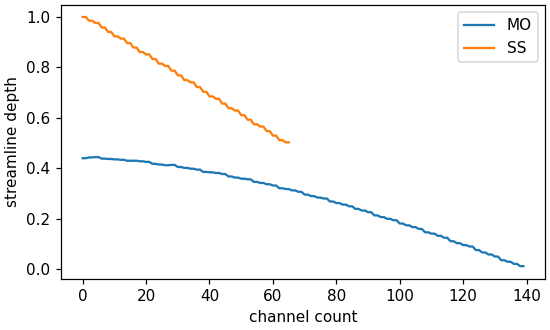

MO: gradient=0.0031, 0.4285 depth
 Distance: 117.4 pixels, 140 chs, 1.677 pix/ch
SS: gradient=0.0077, 0.4974 depth
 Distance: 55.0 pixels, 66 chs, 1.667 pix/ch


Text(0.5, 0, 'channel count')

In [16]:
fig, ax = plt.subplots(figsize=(5,3), constrained_layout=True)

for areax, infox in area_info.items():
    if 'SLdepth' not in infox.keys():
        continue
    ax.plot(infox['SLdepth'], label=areax)
    meangrad = np.mean(np.diff(infox['SLdepth'][::-1]))
    deltadepth = infox['SLdepth'][0] - infox['SLdepth'][-1]
    distance = np.linalg.norm(area_info[areax]['CCF_coords'][0,:] - area_info[areax]['CCF_coords'][-1,:])
    num_chs = len(area_info[areax]['npxchs'])
    print('{}: gradient={:.4f}, {:.4f} depth'.format(areax, meangrad, deltadepth))
    print(' Distance: {:.1f} pixels, {:d} chs, {:.3f} pix/ch'.format(distance, num_chs, distance / (num_chs/2)))
ax.legend()
ax.set_ylabel('streamline depth')
ax.set_xlabel('channel count')

### Can we define a plane tangent to the brain surface near the probe

In [36]:
deltapixel = 25
testarea = 'SS'

## Get probe direction vector ##
probe_vec = area_info[testarea]['CCF_coords'][0,:] - area_info[testarea]['CCF_coords'][-1,:]
unit_probe_vec = probe_vec / np.linalg.norm(probe_vec)
print(unit_probe_vec)

## Define insertion point ##
surfcoords = area_info[testarea]['CCF_coords'][np.argmin(area_info[testarea]['depth']),:]

## Define 3 points surrounding insertion ##
points = [
    surfcoords + [-deltapixel, 0, 0], # moves anterior by deltapixel
    surfcoords + [deltapixel, 0, 0], # moves posterior by deltapixel
    surfcoords + [0, 0, deltapixel], # moves medial by deltapixel
]

## Now find surface level ##
for i, icoords in enumerate(points):
    points[i][1] = np.nonzero(annot[icoords[0], :, icoords[2]])[0][0]

## Use 3 points to define plane tangent(?) to surface ##
p0, p1, p2 = points
x0, y0, z0 = p0
x1, y1, z1 = p1
x2, y2, z2 = p2

ux, uy, uz = u = [x1-x0, y1-y0, z1-z0]
vx, vy, vz = v = [x2-x0, y2-y0, z2-z0]

u_cross_v = [uy*vz-uz*vy, uz*vx-ux*vz, ux*vy-uy*vx]

surf_normal = -np.array(u_cross_v)
surf_unit_normal = surf_normal / np.linalg.norm(surf_normal)
print(surf_unit_normal)

## Degrees between ##
probe_angle = np.degrees(np.arccos(np.dot(unit_probe_vec, surf_unit_normal)))
print('{}: {:.1f} degrees from parallel'.format(testarea, probe_angle))

[0.         0.99983475 0.01817881]
[0.19551547 0.97757736 0.07820619]
SS: 11.8 degrees from parallel


#### Try to plot on CCF annot

In [37]:
tipcoords = area_info[testarea]['CCF_coords'][np.argmax(area_info[testarea]['depth']),:]
print(tipcoords)

surfnormtip = (surfcoords + 150 * surf_unit_normal).astype(int)

[649 153 457]


<IPython.core.display.Javascript object>


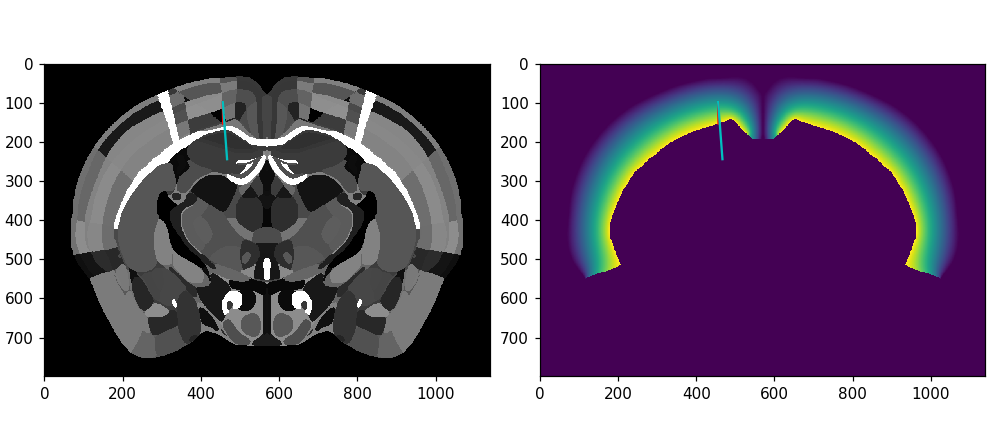

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4), constrained_layout=True)

axs[0].imshow(annot[surfcoords[0],:,:], cmap='gray', aspect='equal', vmin=0, vmax=2000, interpolation='none')
axs[1].imshow(streamlines[surfcoords[0],:,:], interpolation='none')

axs[0].plot([surfcoords[2], tipcoords[2]], [surfcoords[1], tipcoords[1]], color='r')
axs[1].plot([surfcoords[2], tipcoords[2]], [surfcoords[1], tipcoords[1]], color='r')

axs[0].plot([surfcoords[2], surfnormtip[2]], [surfcoords[1], surfnormtip[1]], color='c')
axs[1].plot([surfcoords[2], surfnormtip[2]], [surfcoords[1], surfnormtip[1]], color='c')

### Get slice of CCF along probe insertion line

In [46]:
## get vector between the surface and tip, points from surface to tip ##
probe_vec = area_info[areax]['CCF_coords'][0,:] - area_info[areax]['CCF_coords'][-1,:]
print(probe_vec)

## get the norm and the direction vector ##
norm = np.linalg.norm(probe_vec)
print(norm)
direction = probe_vec / norm # unit vector
print(direction)

[-21  90  19]
94.35041070392857
[-0.22257455  0.95389092  0.20137697]


In [17]:
annot.shape

(1320, 800, 1140)

In [18]:
area_info[areax]['CCF_coords'][0,:]

array([865, 162, 308])

In [19]:
area_info[areax]['CCF_coords'][-1,:]

array([886,  72, 289])

In [20]:
points = [
    area_info[areax]['CCF_coords'][0,:],
    area_info[areax]['CCF_coords'][-1,:],
    area_info[areax]['CCF_coords'][0,:] + [0,300,0],
]
p0, p1, p2 = points
x0, y0, z0 = p0
x1, y1, z1 = p1
x2, y2, z2 = p2

ux, uy, uz = u = [x1-x0, y1-y0, z1-z0]
vx, vy, vz = v = [x2-x0, y2-y0, z2-z0]

u_cross_v = [uy*vz-uz*vy, uz*vx-ux*vz, ux*vy-uy*vx]

point  = np.array(p0)
normal = np.array(u_cross_v)
d = -point.dot(normal)

xx, yy = np.meshgrid(range(annot.shape[0]), range(annot.shape[1]), indexing='ij')
z = (-normal[0] * xx - normal[1] * yy - d) * 1. / normal[2]

In [21]:
CCFslice = np.zeros_like(xx)
SLslice = np.zeros(xx.shape, dtype=float)
for i in range(annot.shape[0]):
    for j in range(annot.shape[1]):
        if z[i,j] > 0:
            CCFslice[i,j] = annot[i, j, int(z[i,j])]
            SLslice[i,j] = streamlines[i, j, int(z[i,j])]

<IPython.core.display.Javascript object>


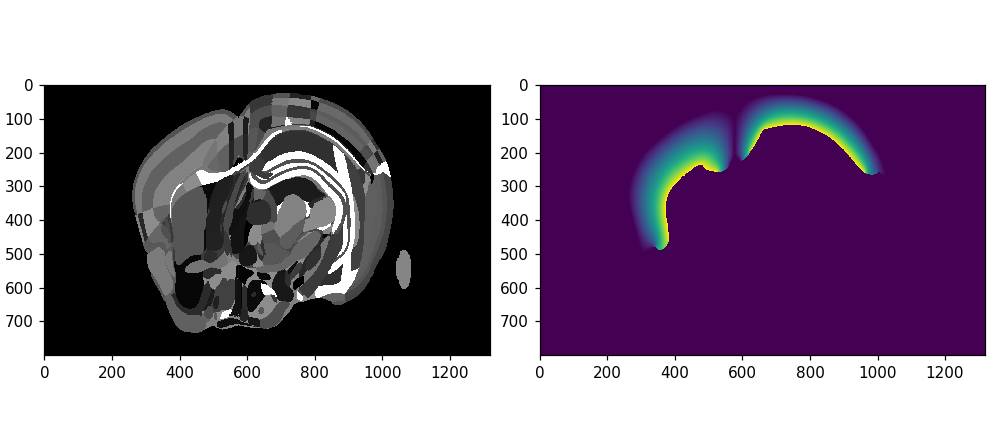

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4), constrained_layout=True)
axs[0].imshow(CCFslice.T, cmap='gray', aspect='equal', vmin=0, vmax=2000, interpolation='none')
axs[1].imshow(SLslice.T, interpolation='none')